# Importing some needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import tensorflow as tf
import random

# Loading Data

In [2]:
# Set random seeds for reproducibility
def set_random_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_random_seeds(42)

# Load data
train_data = pd.read_csv('/kaggle/input/vehicle-recognition/train.csv')
test_data = pd.read_csv('/kaggle/input/vehicle-recognition/test.csv')

In [3]:
# Adjust image paths
train_data['path'] = train_data['path'].apply(lambda x: '/kaggle/input/vehicle-recognition/train/content/' + x)
test_data['path'] = test_data['path'].apply(lambda x: '/kaggle/input/vehicle-recognition/test/content/' + x)

In [4]:
train_data.head()

,path,class
0,/kaggle/input/vehicle-recognition/train/conten...,0
1,/kaggle/input/vehicle-recognition/train/conten...,0
2,/kaggle/input/vehicle-recognition/train/conten...,0
3,/kaggle/input/vehicle-recognition/train/conten...,0
4,/kaggle/input/vehicle-recognition/train/conten...,0


# Visualizing 

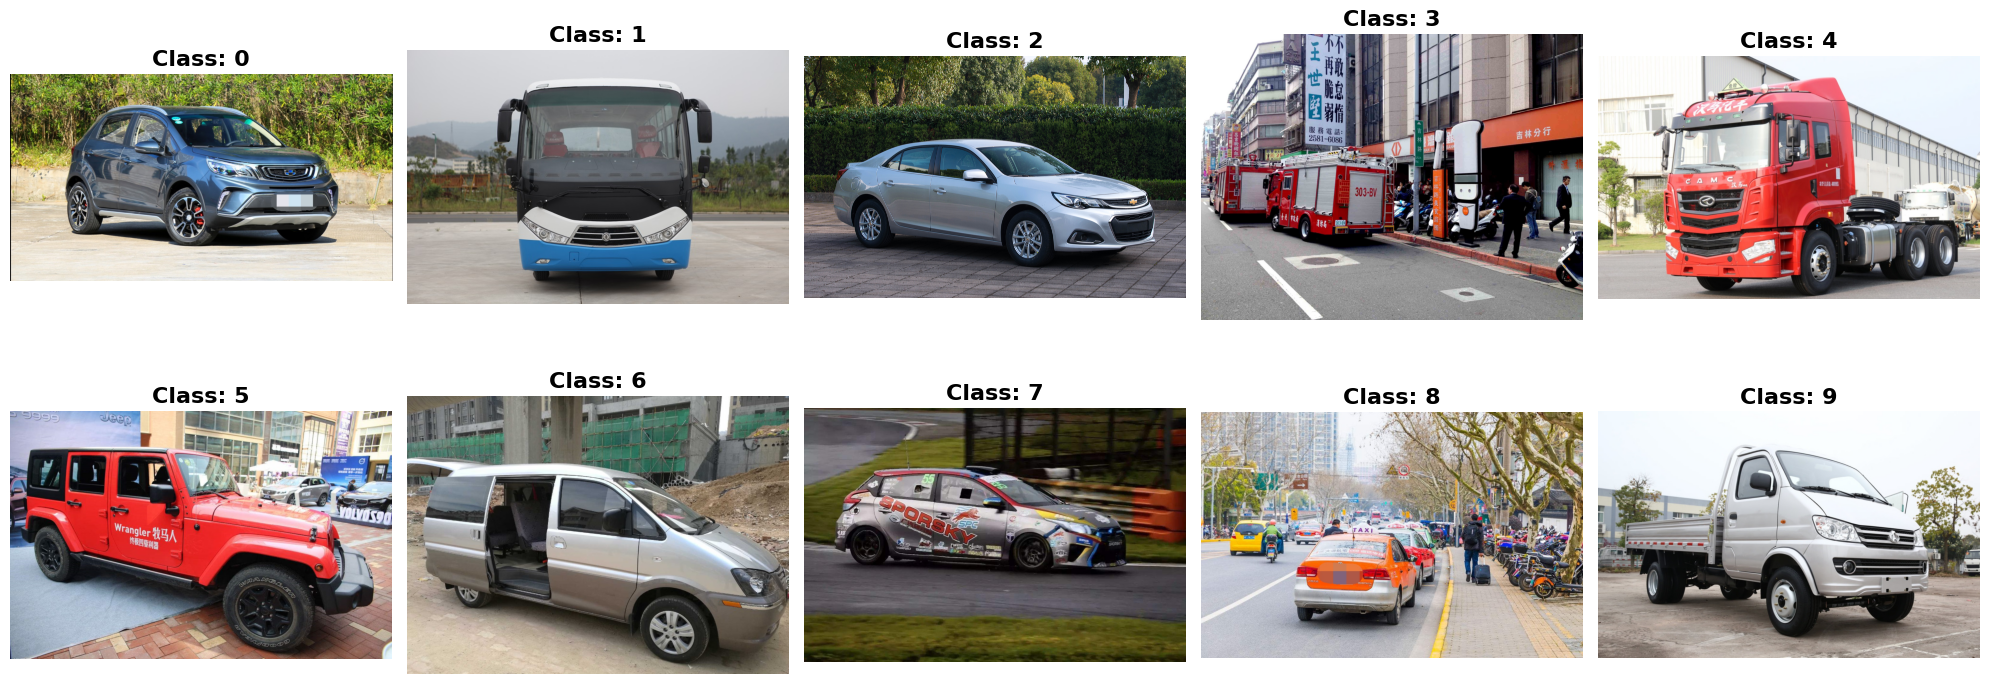

In [5]:
# Set up the plot
fig, axes = plt.subplots(2, 5, figsize=(20, 8)) 
axes = axes.ravel()

# Get a unique list of classes
classes = train_data['class'].unique()

for i, cls in enumerate(classes):
    sample_file = train_data[train_data['class'] == cls].sample(n=1)['path'].values[0]
    
    img = Image.open(sample_file)
    
    axes[i].imshow(img)
    axes[i].set_title(f'Class: {cls}', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    axes[i].axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

# Optimizing Neural Network Training


## Preprocessing Images

In [6]:
import cv2
from sklearn.model_selection import train_test_split

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  #  greyscale
    if image is None:
        print(f"Error reading image {image_path}")
        return None
    image = cv2.resize(image, (128, 128))  # 128x128 pixels resize
    image = image / 255.0  # Normalize pixel values to [0, 1]
    image = np.expand_dims(image, axis=-1)  # Add an extra channel dimension for greyscale
    return image

**Checking :**

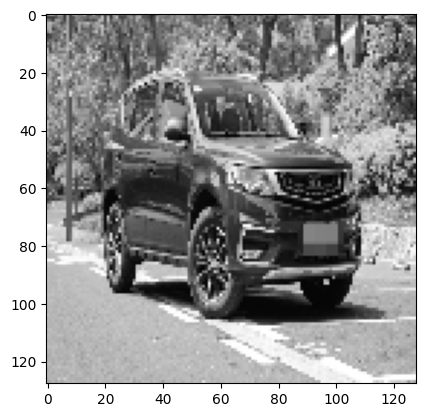

In [7]:
import matplotlib.pyplot as plt

sample_image = preprocess_image(train_data.iloc[0]['path'])

plt.imshow(sample_image , cmap = 'gray')
plt.show()

**128x128 grey**

## splitting data 

In [8]:
train_images = []
train_labels = train_data['class'].values

for path in train_data['path']:
    image = preprocess_image(path)
    if image is not None:
        train_images.append(image)

train_images = np.array(train_images)
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

## Data augmentation to prevent overfitting :

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Model Selection and training

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
model = Sequential([
Conv2D(224,(5,5),(2,2),'same',activation='relu',input_shape=(128,128,1)),
BatchNormalization(),
MaxPooling2D((2, 2)),
Conv2D(112,(5,5),(2,2),'same',activation='relu'),
BatchNormalization(),
MaxPooling2D((2, 2)),
Conv2D(64,(5,5),(2,2),'same',activation='relu'),
BatchNormalization(),
MaxPooling2D((2, 2)),
Flatten(),
Dense(112,activation='relu'),
Dropout(0.5),
Dense(64,activation='relu'),
Dropout(0.5),
Dense(10,activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Model Architecture

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 224)    │         5,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 224)    │           896 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 224)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 112)    │       627,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 112)    │           448 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │       179,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 112)            │        28,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         7,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 850,666 (3.25 MB)

 Trainable params: 849,866 (3.24 MB)

 Non-trainable params: 800 (3.12 KB)

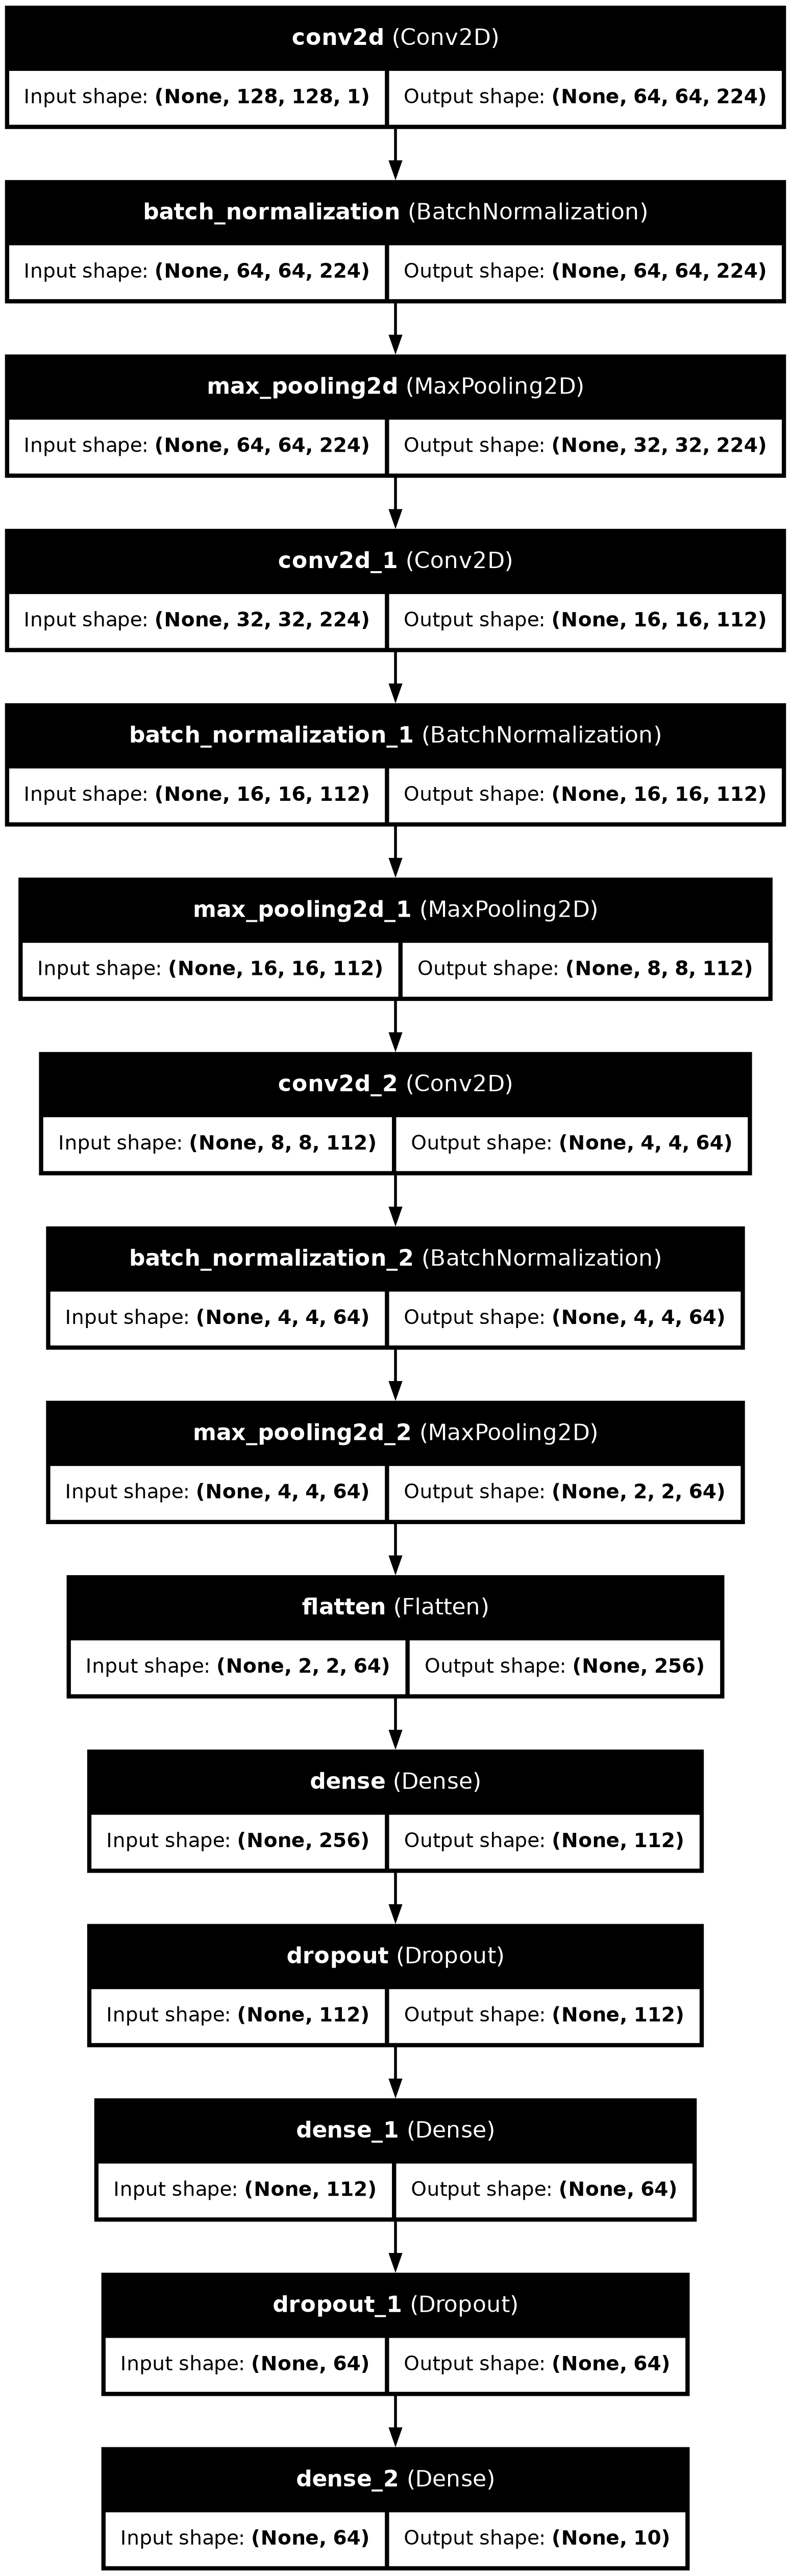

In [12]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=27,
    restore_best_weights=True 
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=8,
    min_lr=0.0001
)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=150,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/150


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1724956897.247275      87 service.cc:145] XLA service 0x7d42d00119b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724956897.247341      87 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724956897.247346      87 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 5/70 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1952 - loss: 3.7297

I0000 00:00:1724956903.538598      87 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.1316 - loss: 3.1248 - val_accuracy: 0.1107 - val_loss: 2.3596 - learning_rate: 0.0010
Epoch 2/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.1352 - loss: 2.3260 - val_accuracy: 0.1107 - val_loss: 2.5356 - learning_rate: 0.0010
Epoch 3/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.1489 - loss: 2.2867 - val_accuracy: 0.1107 - val_loss: 2.5664 - learning_rate: 0.0010
Epoch 4/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.1878 - loss: 2.2078 - val_accuracy: 0.1071 - val_loss: 2.6494 - learning_rate: 0.0010
Epoch 5/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.1762 - loss: 2.1949 - val_accuracy: 0.1036 - val_loss: 2.8482 - learning_rate: 0.0010
Epoch 6/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.1687 - loss: 2.2283 - val_accuracy: 0.1107 - val_loss: 2.6035 - learning_rate: 0.0010
Epoch 7/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.1974 - loss: 2.1608 - val_accurac

# Train Loss / Accuracy vs Epochs

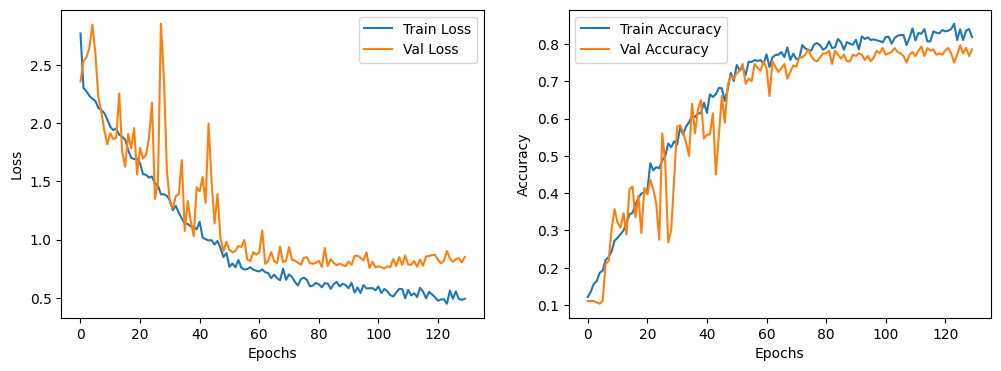

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Predicting

In [15]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_acc}')

test_images = []
for path in test_data['path']:
    image = preprocess_image(path)
    test_images.append(image)

test_images = np.array(test_images)

predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

submission_df = pd.read_csv('/kaggle/input/vehicle-recognition/sample_submission.csv')
submission_df['class'] = predicted_classes
submission_df.to_csv('submission.csv', index=False)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7816 - loss: 0.8207 
Validation Accuracy: 0.7785714268684387
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


In [16]:
submission_df.head()

,path,class
0,test/0419f656d61b42a6b2d567ed9ab6673f.jpg,9
1,test/1401fca7a89ef05e7cd9c154a33966f3.jpg,0
2,test/b62c7d59cd74dc1bc2eaa1b951cfd0a7.jpg,1
3,test/aba61896c1391587795060868f00f6e9.jpg,7
4,test/f9f863d9216a8ea3dfd22dc9775f31ff.jpg,6


In [17]:
def get_class(index):
    if index==0:
        return 'suv'
    elif index==1:
        return 'bus'
    elif index==2:
        return 'family sedan'
    elif index==3:
        return 'fire engine'
    elif index==4:
        return 'heavy truck'
    elif index==5:
        return 'jeep'
    elif index==6:
        return 'minibus'
    elif index==7:
        return 'racing car'
    elif index==8:
        return 'taxi'
    elif index==9:
        return 'truck'

[3.0196747e-05 2.0365621e-04 1.7076043e-02 6.0646411e-04 3.5989319e-06
 1.0502361e-03 1.7212998e-04 8.2704586e-01 1.5381101e-01 7.8954668e-07]
7
racing car


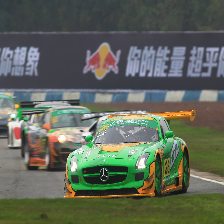

In [18]:
from keras.preprocessing.image import load_img , img_to_array

i = 3

print(predictions[i])
print(np.argmax(predictions[i]))
print(get_class(np.argmax(predictions[i])))
testimg1 = load_img(test_data['path'][i], target_size=(224,224))
testimg1